In [1]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, SpatialDropout2D, ELU
from keras.layers import Conv2D, MaxPooling2D, Cropping2D
from keras.layers.core import Lambda

from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils

from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Using TensorFlow backend.


### Generator

In [46]:
import os
import csv

reduced = False

if reduced == True:
    csv_filepath = 'driving_log_reduced.csv'
else:
    csv_filepath = 'driving_log.csv'
samples = []
with open(csv_filepath) as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
def add_to_samples(csv_filepath, samples):
    with open(csv_filepath) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
    return samples

samples = add_to_samples('./data/driving_log.csv', samples)
print(len(samples))

13451


Before: 13451 13451


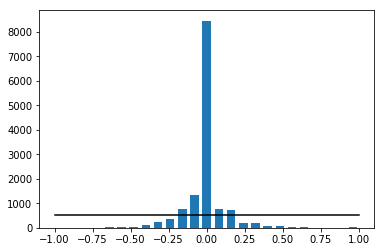

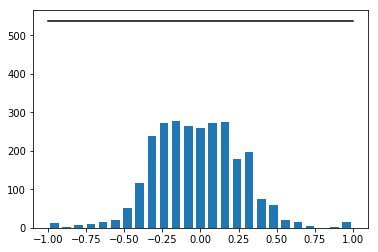

After: 2648 2648
Samples:  2648


In [47]:
image_paths=[]
angles = []
for line in samples:
    image_paths.append(line[0])
    angles.append(float(line[3]))
image_paths = np.array(image_paths)
angles = np.array(angles)

print('Before:', image_paths.shape[0], angles.shape[0])

# print a histogram to see which steering angle ranges are most overrepresented
plt.figure
num_bins = 25
avg_samples_per_bin = len(angles)/num_bins
hist, bins = np.histogram(angles, num_bins)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

# determine keep probability for each bin: if below avg_samples_per_bin, keep all; otherwise keep prob is proportional
# to number of samples above the average, so as to bring the number of samples for that bin down to the average
keep_probs = []
target = avg_samples_per_bin * .5
for i in range(num_bins):
    if hist[i] < target:
        keep_probs.append(1.)
    else:
        keep_probs.append(1./(hist[i]/target))
remove_list = []
for i in range(len(angles)):
    for j in range(num_bins):
        if angles[i] > bins[j] and angles[i] <= bins[j+1]:
            # delete from X and y with probability 1 - keep_probs[j]
            if np.random.rand() > keep_probs[j]:
                remove_list.append(i)
image_paths = np.delete(image_paths, remove_list, axis=0)
angles = np.delete(angles, remove_list)
samples = np.delete(samples, remove_list, axis=0)
# balanced_samples = [v for i, v in enumerate(samples) if i not in del_ind]

# print histogram again to show more even distribution of steering angles
plt.figure
hist, bins = np.histogram(angles, num_bins)
plt.bar(center, hist, align='center', width=width)
plt.plot((np.min(angles), np.max(angles)), (avg_samples_per_bin, avg_samples_per_bin), 'k-')
plt.show()

print('After:', image_paths.shape[0], angles.shape[0])
print('Samples: ', len(samples))

In [48]:
def balance_data(samples, visulization_flag ,N=60, K=0,  bins=50):
    """ Crop the top part of the steering angle histogram, by removing some images belong to those steering angels

    :param images: images arrays
    :param angles: angles arrays 
    :param n:  The values of the histogram bins
    :param bins: The edges of the bins. Length nbins + 1
    :param K: maximum number of max bins to be cropped
    :param N: the max number of the images which will be used for the bin
    :return: images, angle
    """

    angles = []
    for line in samples:
        angles.append(float(line[3]))

    n, bins, patches = plt.hist(angles, bins=bins, color= 'orange', linewidth=0.1)
    angles = np.array(angles)
    n = np.array(n)

    idx = n.argsort()[-K:][::-1]    # find the largest K bins
    del_ind = []                    # collect the index which will be removed from the data
    for i in range(K):
        if n[idx[i]] > N:
            ind = np.where((bins[idx[i]]<=angles) & (angles<bins[idx[i]+1]))
            ind = np.ravel(ind)
            np.random.shuffle(ind)
            del_ind.extend(ind[:len(ind)-N])

    # angles = np.delete(angles,del_ind)
    balanced_samples = [v for i, v in enumerate(samples) if i not in del_ind]
    balanced_angles = np.delete(angles,del_ind)

    plt.subplot(1,2,2)
    plt.hist(balanced_angles, bins=bins, color= 'orange', linewidth=0.1)
    plt.title('modified histogram', fontsize=20)
    plt.xlabel('steering angle', fontsize=20)
    plt.ylabel('counts', fontsize=20)

    if visulization_flag:
        plt.figure
        plt.subplot(1,2,1)
        n, bins, patches = plt.hist(angles, bins=bins, color='orange', linewidth=0.1)
        plt.title('origin histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        plt.show()

        plt.figure
        aa = np.append(balanced_angles, -balanced_angles)
        bb = np.append(aa, aa)
        plt.hist(bb, bins=bins, color='orange', linewidth=0.1)
        plt.title('final histogram', fontsize=20)
        plt.xlabel('steering angle', fontsize=20)
        plt.ylabel('counts', fontsize=20)
        plt.show()

    return balanced_samples

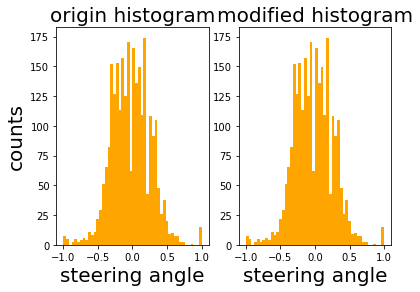

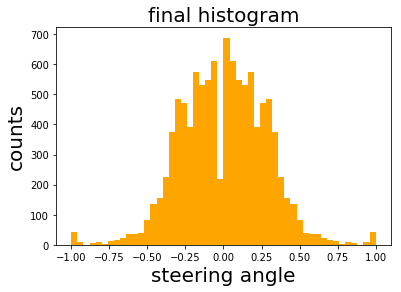

Samples:  2638


In [45]:
# balance the data with smooth the histogram of steering angles
samples = balance_data(samples, visulization_flag=True)

#samples = samples[1:]
print("Samples: ", len(samples))    
from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

In [49]:
def brightness_change(image):
    """  change the brightness of the input image

    :param image: input image
    :return: new image
    """
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = np.random.uniform(0.2,0.8)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)

    return image1


def add_random_shadow(image):
    top_y = 320*np.random.uniform()
    top_x = 0
    bot_x = 160
    bot_y = 320*np.random.uniform()
    image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    shadow_mask = 0*image_hls[:,:,1]
    X_m = np.mgrid[0:image.shape[0],0:image.shape[1]][0]
    Y_m = np.mgrid[0:image.shape[0],0:image.shape[1]][1]

    shadow_mask[((X_m-top_x)*(bot_y-top_y) -(bot_x - top_x)*(Y_m-top_y) >=0)]=1
    #random_bright = .25+.7*np.random.uniform()
    if np.random.randint(2)==1:
        random_bright = .5
        cond1 = shadow_mask==1
        cond0 = shadow_mask==0
        if np.random.randint(2)==1:
            image_hls[:,:,1][cond1] = image_hls[:,:,1][cond1]*random_bright
        else:
            image_hls[:,:,1][cond0] = image_hls[:,:,1][cond0]*random_bright    
    image = cv2.cvtColor(image_hls,cv2.COLOR_HLS2RGB)
    return image


# def add_random_shadow(image):
#     image_hls = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
#     bright_factor = 0.5
#     x = random.randint(0, image.shape[1])
#     y = random.randint(0, image.shape[0])

#     width = random.randint(int(image.shape[1]/2),image.shape[1])
#     if(x+ width > image.shape[1]):
#         x = image.shape[1] - x
#     height = random.randint(int(image.shape[0]/2),image.shape[0])
#     if(y + height > image.shape[0]):
#         y = image.shape[0] - y
#     image_hls[y:y+height,x:x+width,2] = image_hls[y:y+height,x:x+width,2]*bright_factor
# #     image = cv2.cvtColor(image_hls,cv2.COLOR_HSV2RGB)
#     return image_hls


def trans_image(image,steer,trans_range, trans_y=False):
    """
    translate image and compensate for the translation on the steering angle
    """
    
    rows, cols, chan = image.shape
    
    # horizontal translation with 0.008 steering compensation per pixel
    tr_x = trans_range*np.random.uniform()-trans_range/2
    steer_ang = steer + tr_x/trans_range*.4
    
    # option to disable vertical translation (vertical translation not necessary)
    if trans_y:
        tr_y = 40*np.random.uniform()-40/2
    else:
        tr_y = 0

    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])
    image_tr = cv2.warpAffine(image,Trans_M,(cols,rows))

    return image_tr,steer_ang


def data_augmentation(images, angles):
    """ flip every image and change the blitheness of the image, then appended to the lists

    :param images: origin image
    :param angles: origin angles
    :return: added augmented images and their angles
    """
    augmented_images = []
    augmented_angles = []
    for image, angle in zip(images, angles):
        
        # perturb slightly steering direction
#         mu, sigma = 0, 0.1 # mean and standard deviation
#         angle += np.random.normal(mu, sigma)
        
        augmented_images.append(image)
        augmented_angles.append(angle)

        # flip images 
        flipped_image = cv2.flip(image,1)
        flipped_angle = -1.0 * angle
        augmented_images.append(flipped_image)
        augmented_angles.append(flipped_angle)

        # change brightness images
        image_b1 = brightness_change(image)
        image_b2 = brightness_change(flipped_image)
        # append images
        augmented_images.append(image_b1)
        augmented_angles.append(angle)
        augmented_images.append(image_b2)
        augmented_angles.append(flipped_angle)

    return augmented_images, augmented_angles

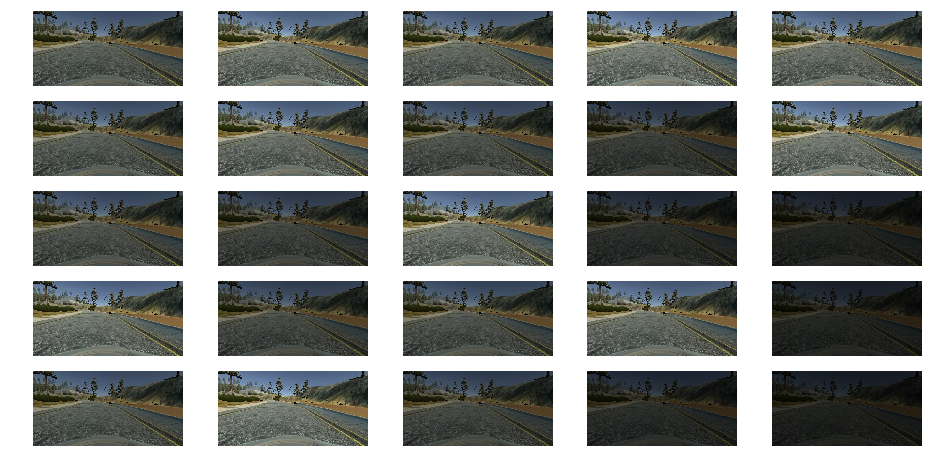

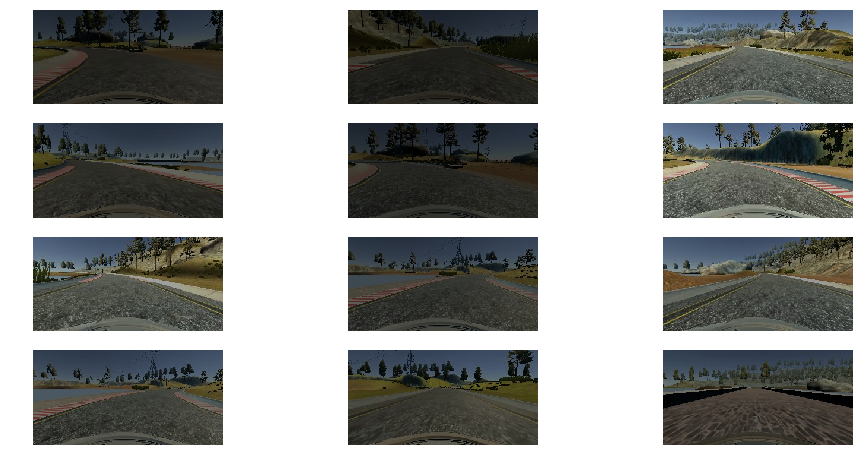

In [50]:

def plotBrightness(samples):
    shuffle(samples)
    num_samples = len(samples)
    
    plot_index = random.randint(0, num_samples)
    sample = samples[plot_index]
    name = sample[0]
    image = mpimg.imread(name)
    plt.figure(figsize=(16,8))
    for i in range(25):               
        image1 = brightness_change(image)
        plt.subplot(5,5,i+1)
        plt.imshow(image1)
        plt.axis('off')
    
    

    plt.figure(figsize=(16,8))
    for i in range(12):
        plot_index = random.randint(0, num_samples)
        sample = samples[plot_index]
        name = sample[0]
        image = mpimg.imread(name)
        image1 = brightness_change(image)
        plt.subplot(4,3,i+1)
        plt.imshow(image1)
        plt.axis('off')
plotBrightness(samples)

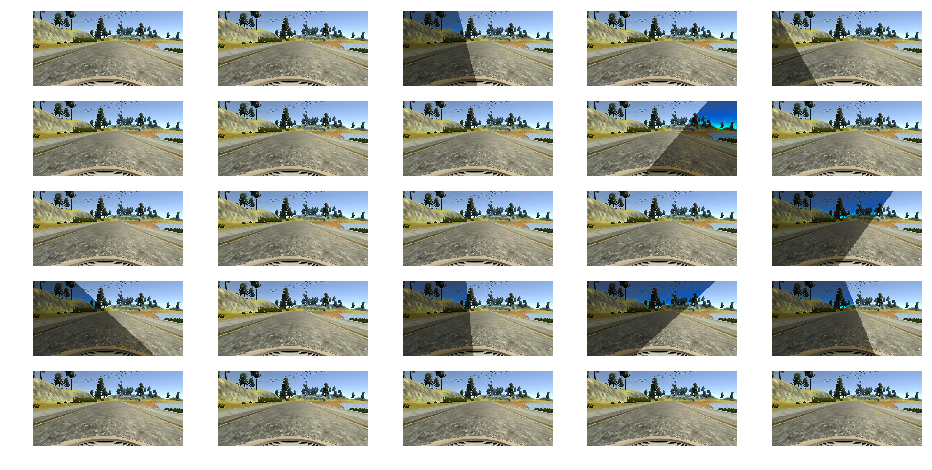

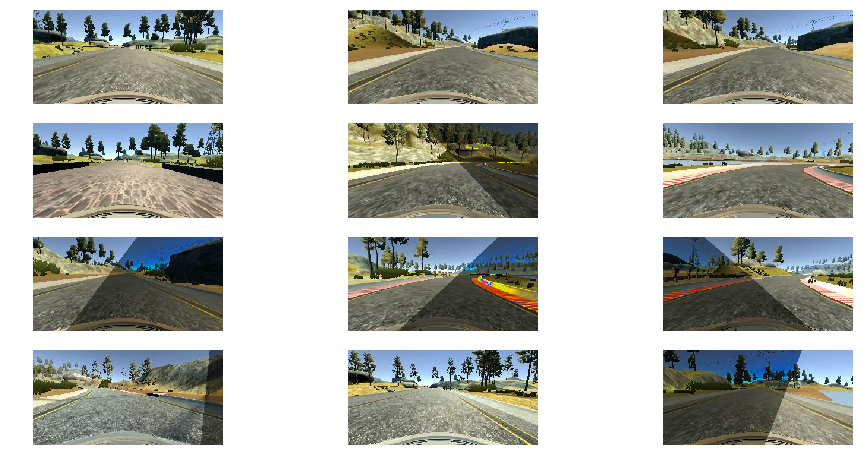

In [51]:

def plotShadow(samples):
    shuffle(samples)
    num_samples = len(samples)
    
    plot_index = random.randint(0, num_samples)
    sample = samples[plot_index]
    name = sample[0]
    image = mpimg.imread(name)
    plt.figure(figsize=(16,8))
    for i in range(25):               
        image1 = add_random_shadow(image)
        plt.subplot(5,5,i+1)
        plt.imshow(image1)
        plt.axis('off')
    
    

    plt.figure(figsize=(16,8))
    for i in range(12):
        plot_index = random.randint(0, num_samples)
        sample = samples[plot_index]
        name = sample[0]
        image = mpimg.imread(name)
        image1 = add_random_shadow(image)
        plt.subplot(4,3,i+1)
        plt.imshow(image1)
        plt.axis('off')
        
plotShadow(samples)

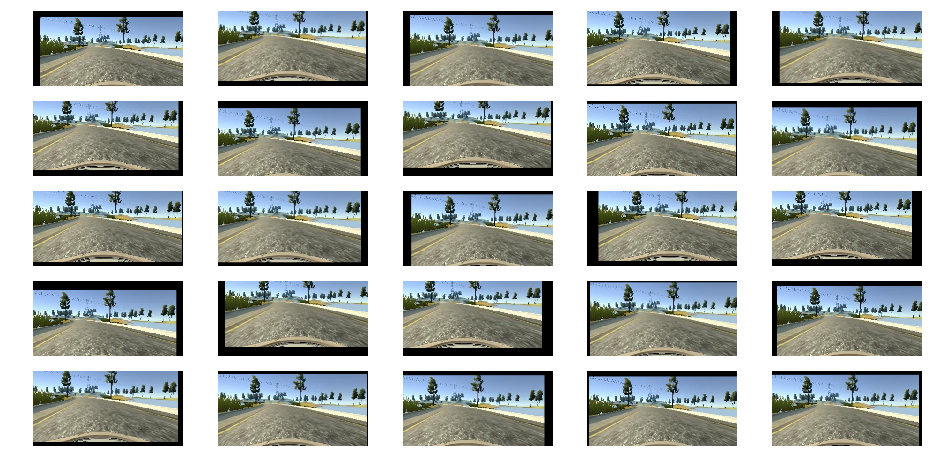

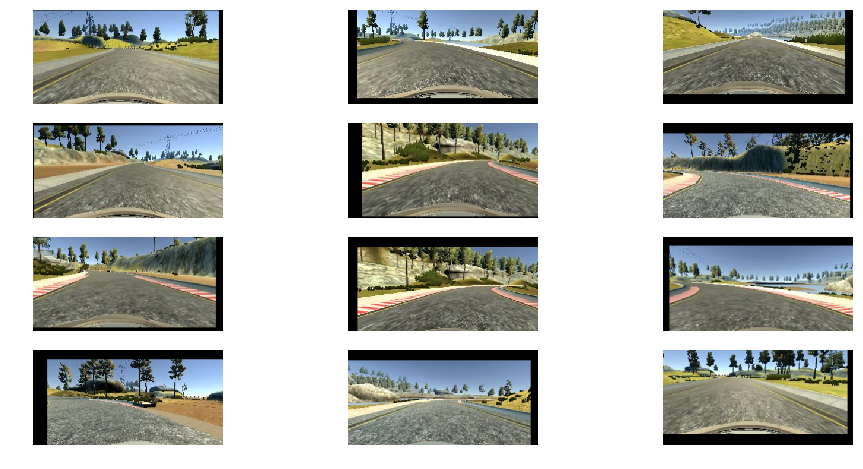

In [52]:

def plotTransImage(samples):
    shuffle(samples)
    num_samples = len(samples)
    
    plot_index = random.randint(0, num_samples)
    sample = samples[plot_index]
    name = sample[0]
    image = mpimg.imread(name)
    angle = float(sample[3])
    plt.figure(figsize=(16,8))
    for i in range(25):               
        image1, angle1 = trans_image(image, angle, 50, 20)
        plt.subplot(5,5,i+1)
        plt.imshow(image1)
        plt.axis('off')
    
    

    plt.figure(figsize=(16,8))
    for i in range(12):
        plot_index = random.randint(0, num_samples)
        sample = samples[plot_index]
        name = sample[0]
        image = mpimg.imread(name)
        angle = float(sample[3])
        image1, angle1 = trans_image(image, angle, 50, 20)
        plt.subplot(4,3,i+1)
        plt.imshow(image1)
        plt.axis('off')
        
plotTransImage(samples)

In [53]:
def generator(samples, train_flag, batch_size=64):
    num_samples = len(samples)
    correction = 0.25 # correction angle used for the left and right images
    
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = batch_sample[0]
                center_image = mpimg.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)
                
                if train_flag:
                    
                    tr_image, tr_angles= trans_image(center_image,center_angle,50,20)
                    images.append(tr_image)
                    angles.append(tr_angles)                   
                    
                    # only add left and right images for training data (not for validation)
                    l_imagePath = line[1].replace(" ", "")
                    r_imagePath = line[2].replace(" ", "")
                    l_image = cv2.imread(l_imagePath)
                    r_image = cv2.imread(r_imagePath)

                    images.append(l_image)
                    angles.append(center_angle + correction)
                    images.append(r_image)
                    angles.append(center_angle - correction)

            # flip image and change the brightness, for each input image, returns other 3 augmented images
            augmented_images, augmented_angles = data_augmentation(images, angles)
            
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_angles)
            
#             print("X_train: ", X_train)
#             print("y_train: ", y_train)
            yield shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, train_flag=True, batch_size=64)
validation_generator = generator(validation_samples, train_flag=False, batch_size=64)

### Models

In [ ]:
def resize_comma(image):
    import tensorflow as tf  # This import is required here otherwise the model cannot be loaded in drive.py
    return tf.image.resize_images(image, 40, 160)

In [54]:
# Comma.ai model
# https://github.com/commaai/research/blob/master/train_steering_model.py

model = Sequential()

model.add(Lambda(lambda x: x / 127.5 - 1, input_shape=(160,320,3)))

# Resize the data
#model.add(Lambda(resize_comma))

# Crop 70 pixels from the top of the image and 25 from the bottom
model.add(Cropping2D(cropping=((70,25),(0,0))))

model.add(Conv2D(24, (5, 5), padding="valid", strides=(2, 2)))
model.add(ELU())
model.add(Dropout(0.2))

model.add(Conv2D(36, (5, 5), padding="valid", strides=(2, 2)))
model.add(ELU())
model.add(Dropout(0.2))

model.add(Conv2D(48, (5, 5), padding="valid", strides=(2, 2)))
model.add(ELU())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="valid"))
model.add(ELU())
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding="valid"))
model.add(ELU())
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(100))
model.add(ELU())
model.add(Dropout(0.5))

model.add(Dense(50))
model.add(ELU())
model.add(Dropout(0.5))

model.add(Dense(10))
model.add(ELU())

model.add(Dense(1))

#adam = Adam(lr=0.0001)

model.compile(optimizer='adam', loss="mse", metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 65, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 158, 24)       1824      
_________________________________________________________________
elu_1 (ELU)                  (None, 31, 158, 24)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 158, 24)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 77, 36)        21636     
_________________________________________________________________
elu_2 (ELU)                  (None, 14, 77, 36)        0         
__________

Data preprocessing reference: [Geoff Breemer](https://carnd-forums.udacity.com/questions/36045049/answers/36047341)

### Train model

# Train model
batch_size = 32
nb_epoch = 20
 
checkpointer = ModelCheckpoint(filepath="./tmp/result.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=False)
    
model.fit_generator(train_generator, 
                    samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator,
                    nb_val_samples=len(validation_samples), nb_epoch=nb_epoch,
                    callbacks=[checkpointer])

In [ ]:
# Train model in Keras 2 API
batch_size = 64
myepochs = 20
 
checkpointer = ModelCheckpoint(filepath="./tmp/result2.{epoch:02d}-{val_loss:.2f}.hdf5", verbose=1, save_best_only=False)
    
model.fit_generator(train_generator, 
                    steps_per_epoch=len(train_samples)//batch_size, 
                    epochs=myepochs,
                    validation_data=validation_generator,
                    validation_steps=len(validation_samples)//batch_size,
                    callbacks=[checkpointer])

Epoch 1/20
32/32 [==============================] - 236s - loss: 0.1738 - acc: 0.0102 - val_loss: 0.0733 - val_acc: 0.0391
Epoch 2/20
31/32 [============================>.] - ETA: 7s - loss: 0.0935 - acc: 0.0117 

In [ ]:
from keras.models import model_from_json

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model.save_weights("model.h5")
print("Saved model to disk")